In [1]:
import pandas as pd
import os
# from wikipedia_crawler import *

## Load 311 doctrine list
- from this page: https://en.wikipedia.org/wiki/Category:Legal_doctrines_and_principles

In [2]:
df = pd.read_csv("./complex-law-doctrine-list.csv")
df['wiki_link'] = df.concept.apply(lambda x: "https://en.wikipedia.org/wiki/" + "_".join(x.split()))
df

,concept,wiki_link
0,Abatement ab initio,https://en.wikipedia.org/wiki/Abatement_ab_initio
1,Abstention doctrine,https://en.wikipedia.org/wiki/Abstention_doctrine
2,Abstraction principle (law),https://en.wikipedia.org/wiki/Abstraction_prin...
3,Acquiescence,https://en.wikipedia.org/wiki/Acquiescence
4,Act of state doctrine,https://en.wikipedia.org/wiki/Act_of_state_doc...
...,...,...
305,Wagoner Doctrine,https://en.wikipedia.org/wiki/Wagoner_Doctrine
306,Wahkohtowin,https://en.wikipedia.org/wiki/Wahkohtowin
307,Warranty tolling,https://en.wikipedia.org/wiki/Warranty_tolling
308,Workers' compensation employer defense,https://en.wikipedia.org/wiki/Workers'_compens...


## Crawl wikipedia pages
- after filtering, 295 doctrines remain

In [3]:
import sys
import time
import argparse
import re
from urllib.parse import urlparse

import requests
from bs4 import BeautifulSoup

def scrap_texts(base_url, article, output_file, html_file):
    """Represents one request per article"""

    full_url = base_url + article
    try:
        r = requests.get(full_url, headers={'User-Agent': USER_AGENT})
    except requests.exceptions.ConnectionError:
        print("Check your Internet connection")
        input("Press [ENTER] to continue to the next request.")
        return
    if r.status_code not in (200, 404):
        print("Failed to request page (code {})".format(r.status_code))
        input("Press [ENTER] to continue to the next request.")
        return
    
    soup = BeautifulSoup(r.text, 'html.parser')
    content = soup.find('div', {'id':'mw-content-text'})

    with open(html_file, 'w', encoding='utf-8') as file:
        file.write(str(content))

    # add new related articles to queue
    # check if are actual articles URL
    for a in content.find_all('a'):
        href = a.get('href')
        if not href:
            continue
        if href[0:6] != '/wiki/':  # allow only article pages
            continue
        elif ':' in href:  # ignore special articles e.g. 'Special:'
            continue
        elif href[-4:] in ".png .jpg .jpeg .svg":  # ignore image files inside articles
            continue
        elif base_url + href in visited_urls:  # already visited
            continue
        if href in pending_urls:  # already added to queue
            continue
        pending_urls.append(href)

    # skip if already added text from this article, as continuing session
    if full_url in visited_urls:
        return
    visited_urls.add(full_url)

    parenthesis_regex = re.compile('\(.+?\)')  # to remove parenthesis content
    citations_regex = re.compile('\[.+?\]')  # to remove citations, e.g. [1]

    # get plain text from each <p>
    p_list = content.find_all('p')
    with open(output_file, 'a', encoding='utf-8') as fout:
        for p in p_list:
            text = p.get_text().strip()
            text = parenthesis_regex.sub('', text)
            text = citations_regex.sub('', text)
            if text:
                fout.write(text + '\n\n')  # extra line between paragraphs

response = requests.get('https://en.wikipedia.org/w/api.php', 
                        params={'action': 'query',
                                'format': 'json',
                                'titles': 'Abstention_doctrine',
                                'prop': 'extracts',
                                'exintro': True,
                                'explaintext': True,})
soup = BeautifulSoup(response.text, 'html.parser')

In [4]:
# page_id = list(data["query"]["pages"].keys())[0]
# data["query"]["pages"][page_id]["extract"]
data = response.json()
page_id = list(data["query"]["pages"].keys())[0]
data["query"]["pages"][page_id]["extract"]

"An abstention doctrine is any of several doctrines that a United States court may (or in some cases must) apply to refuse to hear a case if hearing the case would potentially intrude upon the powers of another court. Such doctrines are usually invoked where lawsuits involving the same issues are brought in two different court systems at the same time (such as federal and state courts).\nThe United States has a federal court system with limitations on the cases that it can hear, while each state has its own individual court system. In some instances, the jurisdiction of these courts overlap, so a lawsuit between two parties may be brought in either or both courts. The latter circumstance can lead to confusion, waste resources, as well as cause the appearance that one court is disrespecting the other. Both federal and state courts have developed rules determining when one court will defer to another's jurisdiction over a particular case."

In [5]:
# DEFAULT_OUTPUT = 'output.txt'
DEFAULT_INTERVAL = 1.0  # interval between requests (seconds)
DEFAULT_ARTICLES_LIMIT = 400  # total number articles to be extrated
USER_AGENT = 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/52.0.2743.116 Safari/537.36'

visited_urls = set()  # all urls already visited, to not visit twice
pending_urls = []  # queue

for row in df.iloc[:].iterrows():
    row = row[1]
    concept, initial_url = row.concept, row.wiki_link
    # interval = DEFAULT_INTERVAL
    # articles_limit = DEFAULT_ARTICLES_LIMIT

    # minutes_estimate = interval * articles_limit / 60
    # print("This session will take {:.1f} minute(s) to download {} article(s):".format(minutes_estimate, articles_limit))
    # print("\t(Press CTRL+C to pause)\n")
    concept_string = "_".join(concept.split())
    output_file = "./crawled_data/intro_raw/{}.txt".format(concept_string)
    # html_file = "./crawled_data/html/{}.html".format(concept_string)
    
    # base_url = '{uri.scheme}://{uri.netloc}'.format(uri=urlparse(initial_url))
    # initial_url = initial_url[len(base_url):]
    # pending_urls.append(initial_url)

    # next_url = pending_urls.pop(0)
    # scrap_texts(base_url, next_url, output_file, html_file)
    response = requests.get('https://en.wikipedia.org/w/api.php', 
                        params={'action': 'query',
                                'format': 'json',
                                'titles': concept_string,
                                'prop': 'extracts',
                                'exintro': True,
                                'explaintext': True,})
    data = response.json()
    page_id = list(data["query"]["pages"].keys())[0]
    if ("extract" in data["query"]["pages"][page_id]):
        intro_text = data["query"]["pages"][page_id]["extract"]
        if len(intro_text.strip()) > 10: 
            with open(output_file, "w") as out:
                out.write(intro_text)


## Filter the raw texts --> 295 doctrines

In [5]:
rows = []
for row in df.iterrows():
    row = row[1]
    concept, initial_url = row.concept, row.wiki_link
    concept_string = "_".join(concept.split())
    filename = "./crawled_data/intro_raw/{}.txt".format(concept_string)
    if os.path.isfile(filename):
        with open(filename) as f:
            raw_text = f.read()
            num_words = len(raw_text.split())
            # if 150 < num_words < 500:
            rows.append([concept_string, raw_text, num_words])
df_rows = pd.DataFrame(rows, columns=['concept', 'intro_text', "word_count"])    
df_rows.to_csv("../data/295-doctrines/legal_doctrines_295.tsv", sep="\t", index=False)
df_rows.shape


(295, 3)

## Sample 102 doctrines out of 295 doctrines
- we pick doctrines whose definition length is between 100 and 200 words

In [7]:
df_medium_length = df_rows[df_rows.word_count <= 200]
df_medium_length = df_medium_length[df_medium_length.word_count >= 100]
print(df_medium_length.shape)

df_medium_length.to_csv("../data/102-doctrines/legal_doctrines_102.tsv", sep="\t", index=False)

(102, 3)


(array([0.02042484, 0.01429739, 0.01429739, 0.01021242, 0.01021242,
        0.0122549 , 0.01633987, 0.0122549 , 0.01021242, 0.01021242,
        0.00816993, 0.01838235, 0.00816993, 0.00204248, 0.00408497,
        0.00612745, 0.01021242, 0.        , 0.00408497, 0.01633987]),
 array([100. , 104.8, 109.6, 114.4, 119.2, 124. , 128.8, 133.6, 138.4,
        143.2, 148. , 152.8, 157.6, 162.4, 167.2, 172. , 176.8, 181.6,
        186.4, 191.2, 196. ]),
 <BarContainer object of 20 artists>)

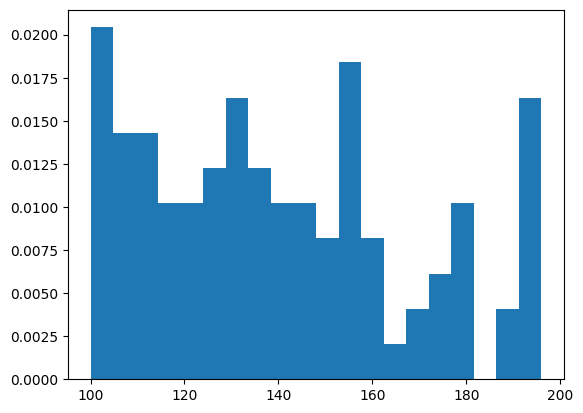

In [10]:
import matplotlib.pyplot as plt
plt.hist(df_medium_length.word_count, density=True, bins=20)  


In [13]:
print("102 doctrine definition's median length ->", df_medium_length.word_count.median())
print("102 doctrine definition's mean length ->", df_medium_length.word_count.mean())

102 doctrine definition's median length -> 135.5
102 doctrine definition's mean length -> 140.01960784313727


## Sample 20 doctrines from 102 for detailed evaluation

In [13]:
df_sampled_20 = df_medium_length.sample(frac=0.2)
df_sampled_20

,concept,intro_text,word_count
0,Abstention_doctrine,An abstention doctrine is any of several doctr...,159
11,Constitutional_convention_(political_custom),A constitutional convention is an informal and...,179
94,Unaccompanied_minor,"An unaccompanied minor (sometimes ""unaccompani...",105
90,Substantial_certainty_doctrine,"In law, the substantial certainty doctrine is ...",103
50,Learned_intermediary,Learned intermediary is a defense doctrine use...,105
18,Doctrine_of_foreign_equivalents,This article discusses the trademark doctrine ...,129
78,Prosecutorial_discretion,"In common law, the principle of prosecutorial ...",104
87,Safe_harbor_(law),A safe harbor is a provision of a statute or a...,153
35,FTC_v._Dean_Foods_Co.,"FTC v. Dean Foods Co., 384 U.S. 597 (1966), is...",119
100,Volenti_non_fit_injuria,"Volenti non fit iniuria (or injuria) (Latin: ""...",196


In [14]:
df_sampled_20.to_csv("../data/20-doctrines/legal_doctrines_20.tsv", sep="\t")